# Prétraitement

Notebook traitant les formats et les valeurs manquantes dans le but de créer un dataframe adapté à l'input d'un réseau de neurones. 

Le traitement des valeurs manquantes est lent et critiquable : il est probablement possible de créer des programmes beaucoup plus efficaces pour traiter les valeurs manquantes. Notamment, nous n'avons pas pu utiliser les fonctions générales existantes d'interpolation, qui brutaient énormement nos séries. Une bouche "for" est donc utilisée pour le traitement, d'où la lenteur de nos programmes. 
De plus, un programme traitant uniquement les valeurs manquantes sans passer en revue toute la série, aurait été plus performant. 

Le traitement des valeurs manquantes n'étant pas le coeur de notre projet, et le temps nous étant compté, nous ne tentons pas d'améliorer l'efficacité des programmes rédigés dans ce notebook. 

In [1]:
# Importation des packages 
import os 
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates
from random import *

In [2]:
path_safran = 'C:/Users/louis/OneDrive/Documents/ENSAE/2A/Safran/db_anonymisee_23112020.csv'
safran=pd.read_csv(path_safran,sep=';')

In [ ]:
safran.head()

In [ ]:
safran.shape

Nous avons sous la main une base de données d'environ 3 millions de lignes, chacune est représenté par 25 variables. 

In [ ]:
safran['engine_serial_number'].nunique()

### 1. Les formats 

In [ ]:
safran.dtypes

Certaines variables ont un format qui ne leur correspond pas, réglons cela : 

In [ ]:
# Transformation du format de la variable date en datetime 
safran['date'] = pd.to_datetime(safran['date'], format="%Y/%m/%d %H:%M:%S")

In [ ]:
# Transformation du format des variable egt_margin, cycles, var_mot_1,flight_leg_hours et les variables environnementales 
# continues  en float (sauf pour les valeurs 'nan')
def replace_value (x):
    try: 
        return x.replace(",", ".")
    except AttributeError:
        return np.NaN
safran['egt_margin'] = safran['egt_margin'].map(replace_value)
safran['egt_margin']=pd.to_numeric(safran['egt_margin'])
safran['cycles'] = safran['cycles'].map(replace_value)
safran['cycles']=pd.to_numeric(safran['cycles'])
safran['var_mot_1']=safran['var_mot_1'].map(replace_value)
safran['var_mot_1']=pd.to_numeric(safran['var_mot_1'])
safran['flight_leg_hours']=safran['flight_leg_hours'].map(replace_value)
safran['flight_leg_hours']=pd.to_numeric(safran['flight_leg_hours'])
safran['egt_slope']=safran['egt_slope'].map(replace_value)
safran['egt_slope']=pd.to_numeric(safran['egt_slope'])
safran['var_env_1']=safran['var_env_1'].map(replace_value)
safran['var_env_1']=pd.to_numeric(safran['var_env_1'])
safran['var_env_2']=safran['var_env_2'].map(replace_value)
safran['var_env_2']=pd.to_numeric(safran['var_env_2'])
safran['var_env_3']=safran['var_env_3'].map(replace_value)
safran['var_env_3']=pd.to_numeric(safran['var_env_3'])
safran['var_env_5']=safran['var_env_5'].map(replace_value)
safran['var_env_5']=pd.to_numeric(safran['var_env_5'])

In [ ]:
safran.dtypes

## 2. Les valeurs manquantes 

In [ ]:
safran.isnull().sum()

In [ ]:
safran.head(20)

De nombreuses variables ont un nombre important de valeurs manquantes.

###  2.1 Traitement des valeurs manquantes pour egt_margin

In [ ]:
print(' Part des valeurs manquantes pour egt_margin : ', int(safran['egt_margin'].isnull().sum() /safran['egt_margin'].size * 100),'%')

egt_margin est la variable que nous cherchons à expliquer. Pour pouvoir entrainer et tester notre futur modèle il nous faudra l'ensemble des données. Il faut donc traiter les valeurs manquantes, qui représentent une part importante du dataframe pour cette varible (34%).  

Pour cela nous proposons d'appliquer l'interpolation des données manquantes. 

Nous traitons séparemment les différents avions :

In [ ]:
print('Taille de la base complete :', safran.shape[0], '\n', 'Nombre d\'avions : ', safran['engine_serial_number'].nunique())

In [ ]:
safran.groupby(by=['engine_serial_number']).size().describe()

En moyenne, un avion est représenté par 2 000 vols (écart type de 1 500). 

Au minimum un avion est représenté par 1 vol. Dans notre base, le maximum est de 7 919 vols pour un avion. 

Effectuons quelques analyses exploratoires pour un avion en particulier : Celui représenté par le moteur ESN_1 :

In [ ]:
Avion1= safran[safran['engine_serial_number']=='ESN_1']
Avion1

In [ ]:
Avion1['egt_margin'].isnull().sum()

Testons l'interpolation pour le premier avion 

In [ ]:
# On commence par indexer le DataFrame par les dates 
Avion1.index = Avion1['date']
del Avion1['date']

In [ ]:
# Méthode "Time" car importance du temps
Avion1 = Avion1.assign(InterpolateTime=Avion1.egt_margin.interpolate(method='time'))

In [ ]:
Avion1['InterpolateTime'].plot(figsize = (16,6))

In [ ]:
Avion1['egt_margin'].plot(figsize = (16,6))

On teste sur la base complète :

In [ ]:
safran_test = safran.copy()
safran_test.index = safran_test['date']
del safran_test['date']

In [ ]:
safran_test.groupby('engine_serial_number')
safran_test=safran_test.assign(InterpolateTime=safran_test.egt_margin.interpolate(method='time'))

In [ ]:
safran_test.InterpolateTime.isnull().sum()

In [ ]:
safran_test[safran_test['engine_serial_number']=='ESN_1']['InterpolateTime'].plot(figsize = (16,6))

Ressemble pas ... 

Testons un par un pour limiter le bruit :

In [ ]:
# Cette cellule est relativement longue ( de l'ordre de 10-15 minutes)
# On divise en deux pour limiter le temps de calcul

series = safran['engine_serial_number'].unique()
series_1,series_2 = series[0: int(len(series)/2)], series[int(len(series)/2):int(len(series))]

calage_1 = series_1[0]
calage_2 = series_2[0]

Avion_1= safran[safran['engine_serial_number']==calage_1]
Avion_2= safran[safran['engine_serial_number']==calage_2]
series_1=np.delete(series_1,0)
series_2=np.delete(series_2,0)

Avion_1.index = Avion_1['date']
del Avion_1['date']
Avion_1 = Avion_1.assign(Interpolate_egt_margin=Avion_1.egt_margin.interpolate(method='time'))

Avion_2.index = Avion_2['date']
del Avion_2['date']
Avion_2 = Avion_2.assign(Interpolate_egt_margin=Avion_2.egt_margin.interpolate(method='time'))

for i in series_1 : 
    avion_i= safran[safran['engine_serial_number']==i]
    avion_i.index = avion_i['date']
    del avion_i['date']
    avion= avion_i.assign(Interpolate_egt_margin=avion_i.egt_margin.interpolate(method='time'))
    Avion_1 = pd.concat( [Avion_1,avion])
    print("Chargement de l'avion", i, " sur ", "la première serie (jusqu'à :",series_1[-1],")")

for i in series_2 : 
    avion_i= safran[safran['engine_serial_number']==i]
    avion_i.index = avion_i['date']
    del avion_i['date']
    avion= avion_i.assign(Interpolate_egt_margin=avion_i.egt_margin.interpolate(method='time'))
    Avion_2 = pd.concat( [Avion_2,avion])
    print("Chargement de l'avion", i, " sur ", "la deuxieme serie (jusqu'à :",series_2[-1],")")

    
Avions=pd.concat([Avion_1,Avion_2])

In [ ]:
# Affichage de l'évolution de la marge egt au cours du temps pour un avion tiré au hasard
n=randint(0,len(series))
Avions[Avions['engine_serial_number']==series[n]]['Interpolate_egt_margin'].plot(figsize = (16,6))

In [ ]:
# Verifions qu'il n'y a plus de valeur manquante pour la marge egt 
Avions.Interpolate_egt_margin.isnull().sum()

### 2.2 Traitement des valeurs manquantes pour var_mot_1

In [ ]:
# Création d'une copie de Avions en cas d'erreur 
Test= Avions.copy()

In [ ]:
Test.var_mot_1.isnull().sum() # Variable d'utilisation du moteur 

In [ ]:
print(' Le nombre de valeurs manquantes pour la variable var_moteur est de ', Test.var_mot_1.isnull().sum()/Test.var_mot_1.shape[0]*100, '%')

In [ ]:
# Exemple pour l'avion représenté par le moteur ESN_1
Avion1['var_mot_1'].plot(figsize = (16,6))

De la même façon que pour la variable egt_margin on effectue une interpolation temporelle. 

In [ ]:
# On fait deux boucles pour limiter le temps de calculs 
# Attention il faut quand même compter 10 minutes pour effectuer cette cellule  
Avion_1= Test[Test['engine_serial_number']==calage_1]
Avion_1 = Avion_1.assign(Interpolate_var_mot_1=Avion_1.var_mot_1.interpolate(method='time'))

Avion_2= Test[Test['engine_serial_number']==calage_2]
Avion_2 = Avion_2.assign(Interpolate_var_mot_1=Avion_2.var_mot_1.interpolate(method='time'))


for i in series_1 :
    avion_i= Test[Test['engine_serial_number']==i]
    avion= avion_i.assign(Interpolate_var_mot_1=avion_i.var_mot_1.interpolate(method='time'))
    Avion_1=pd.concat( [Avion_1,avion])
    print("Chargement de l'avion", i, " sur ", "la première serie (jusqu'à :",series_1[-1],")")
    
for i in series_2 : 
    avion_i= Test[Test['engine_serial_number']==i]
    avion= avion_i.assign(Interpolate_var_mot_1=avion_i.var_mot_1.interpolate(method='time'))
    Avion_2 = pd.concat( [Avion_2,avion])
    print("Chargement de l'avion", i, " sur ", "la deuxieme serie (jusqu'à :",series_2[-1],")")

    
Avions=pd.concat([Avion_1,Avion_2])

In [ ]:
Avions

In [ ]:
# Affichage de l'évolution la variable d'utilisation du moteur  au cours du temps pour un avion tiré au hasard
n=randint(0,len(series))

In [ ]:
#Affichage avant traitement des valeurs manquantes :
Avions[Avions['engine_serial_number']==series[n]]['var_mot_1'].plot(figsize = (16,6))

In [ ]:
# Après traitement :
Avions[Avions['engine_serial_number']==series[n]]['Interpolate_var_mot_1'].plot(figsize = (16,6))

In [ ]:
Avions['Interpolate_var_mot_1'].isnull().sum()

### 2.3 Traitement des valeurs manquantes pour flight_leg_hours

In [ ]:
# Création d'une copie de Avions en cas d'erreur 
Test= Avions.copy()

In [ ]:
Test.flight_leg_hours.isnull().sum() # Durée des vols

In [ ]:
# Représentation pour le premier avion ESN_1
Avion1['flight_leg_hours'].plot(figsize = (16,6))

In [ ]:
# On fait deux boucles pour limiter le temps de calculs 
# Attention il faut quand même compter 10 minutes pour effectuer cette cellule  
Avion_1= Test[Test['engine_serial_number']==calage_1]
Avion_1 = Avion_1.assign(Interpolate_flight_leg_hours=Avion_1.flight_leg_hours.interpolate(method='time'))

Avion_2= Test[Test['engine_serial_number']==calage_2]
Avion_2 = Avion_2.assign(Interpolate_flight_leg_hours=Avion_2.flight_leg_hours.interpolate(method='time'))


for i in series_1 :
    avion_i= Test[Test['engine_serial_number']==i]
    avion= avion_i.assign(Interpolate_flight_leg_hours=avion_i.flight_leg_hours.interpolate(method='time'))
    Avion_1=pd.concat( [Avion_1,avion])
    print("Chargement de l'avion", i, " sur ", "la première serie (jusqu'à :",series_1[-1],")")
    
for i in series_2 : 
    avion_i= Test[Test['engine_serial_number']==i]
    avion= avion_i.assign(Interpolate_flight_leg_hours=avion_i.flight_leg_hours.interpolate(method='time'))
    Avion_2 = pd.concat( [Avion_2,avion])
    print("Chargement de l'avion", i, " sur ", "la deuxieme serie (jusqu'à :",series_2[-1],")")

    
Avions=pd.concat([Avion_1,Avion_2])

In [ ]:
# Affichage de l'évolution la variable de durée de vols au cours du temps pour un avion tiré au hasard
n=randint(0,len(series))
Avions[Avions['engine_serial_number']==series[n]]['Interpolate_flight_leg_hours'].plot(figsize = (16,6))

In [ ]:
#Vérifions qu'il n'y a plus de valeur manquantes
Test['Interpolate_flight_leg_hours'].isnull().sum()

In [ ]:
Test = Avions.copy()

In [ ]:
# On fait deux boucles pour limiter le temps de calculs 
# Attention il faut quand même compter 10 minutes pour effectuer cette cellule  
Avion_1= Test[Test['engine_serial_number']==calage_1]
Avion_1 = Avion_1.assign(Interpolate_flight_leg_hours=Avion_1.Interpolate_flight_leg_hours.interpolate(method='time', limit_direction='backward'))

Avion_2= Test[Test['engine_serial_number']==calage_2]
Avion_2 = Avion_2.assign(Interpolate_flight_leg_hours=Avion_2.Interpolate_flight_leg_hours.interpolate(method='time', limit_direction='backward'))


for i in series_1 :
    avion_i= Test[Test['engine_serial_number']==i]
    avion= avion_i.assign(Interpolate_flight_leg_hours=avion_i.Interpolate_flight_leg_hours.interpolate(method='time', limit_direction='backward'))
    Avion_1=pd.concat( [Avion_1,avion])
    print("Chargement de l'avion", i, " sur ", "la première serie (jusqu'à :",series_1[-1],")")
    
for i in series_2 : 
    avion_i= Test[Test['engine_serial_number']==i]
    avion= avion_i.assign(Interpolate_flight_leg_hours=avion_i.Interpolate_flight_leg_hours.interpolate(method='time', limit_direction='backward'))
    Avion_2 = pd.concat( [Avion_2,avion])
    print("Chargement de l'avion", i, " sur ", "la deuxieme serie (jusqu'à :",series_2[-1],")")

    
Avions=pd.concat([Avion_1,Avion_2])

In [ ]:
#Vérifions qu'il n'y a plus de valeur manquantes
Test['Interpolate_flight_leg_hours'].isnull().sum()

In [ ]:
Avions[Avions['Interpolate_flight_leg_hours'].isnull()==True]['engine_serial_number'].nunique()

Probleme pour 67 moteurs 

### 2.4 Traitement des valeurs manquantes pour egt_slope 

In [ ]:
Avions.egt_slope.isnull().sum() # Pente egt entre deux événements 

On revient sur le traitement de ces valeurs en fin de notebook. 

### 2.5 Traitement des valeurs manquantes pour SV_rank 

In [ ]:
Avions.SV_rank.isnull().sum() # Nombre de fois passé en maintenance 

In [ ]:
Avion1['SV_rank'].plot(figsize = (16,6))

Linéaire, on ne peut aller que de 1 en 1 : On utilise la méthode pad (se sert des valeurs existantes). 

In [ ]:
Test=Avions.copy()
Test

In [ ]:
Avion_1= Test[Test['engine_serial_number']==calage_1]
Avion_1 = Avion_1.assign(Interpolate_SV_rank=Avion_1.SV_rank.interpolate(method='pad'))

In [ ]:
# On fait deux boucles pour limiter le temps de calculs 
# Attention il faut quand même compter 10 minutes pour effectuer cette cellule  
Avion_1= Test[Test['engine_serial_number']==calage_1]
Avion_1 = Avion_1.assign(Interpolate_SV_rank=Avion_1.SV_rank.interpolate(method='pad'))

Avion_2= Test[Test['engine_serial_number']==calage_2]
Avion_2 = Avion_2.assign(Interpolate_SV_rank=Avion_2.SV_rank.interpolate(method='pad'))


for i in series_1 :
    avion_i= Test[Test['engine_serial_number']==i]
    avion= avion_i.assign(Interpolate_SV_rank=avion_i.SV_rank.interpolate(method='pad'))
    Avion_1=pd.concat( [Avion_1,avion])
    print("Chargement de l'avion", i, " sur ", "la première serie (jusqu'à :",series_1[-1],")")
    
for i in series_2 : 
    avion_i= Test[Test['engine_serial_number']==i]
    avion= avion_i.assign(Interpolate_SV_rank=avion_i.SV_rank.interpolate(method='pad'))
    Avion_2 = pd.concat( [Avion_2,avion])
    print("Chargement de l'avion", i, " sur ", "la deuxieme serie (jusqu'à :",series_2[-1],")")


Avions=pd.concat([Avion_1,Avion_2])

In [ ]:
# Affichage de l'évolution du nombre de SV effectué sur un moteur
n=randint(0,len(series))
print(n)
Avions[Avions['engine_serial_number']==series[n]]['Interpolate_SV_rank'].plot(figsize = (16,6))

In [ ]:
# On vérifie qu'il n'y a plus de valeur manquante :
Avions.Interpolate_SV_rank.isnull().sum()

### 2.6 Traitement des valeurs manquantes pour Config_B_rank 

In [ ]:
Avions.Config_B_rank.isnull().sum() # Changement de format de la piece B

In [ ]:
Avion1['Config_B_rank'].plot(figsize = (16,6))

In [ ]:
Test=Avions.copy()

In [ ]:
# On fait deux boucles pour limiter le temps de calculs 
# Attention il faut quand même compter 10 minutes pour effectuer cette cellule  
Avion_1= Test[Test['engine_serial_number']==calage_1]
Avion_1 = Avion_1.assign(Interpolate_Config_B_rank=Avion_1.Config_B_rank.interpolate(method='pad'))

Avion_2= Test[Test['engine_serial_number']==calage_2]
Avion_2 = Avion_2.assign(Interpolate_Config_B_rank=Avion_2.Config_B_rank.interpolate(method='pad'))


for i in series_1 :
    avion_i= Test[Test['engine_serial_number']==i]
    avion= avion_i.assign(Interpolate_Config_B_rank=avion_i.Config_B_rank.interpolate(method='pad'))
    Avion_1=pd.concat( [Avion_1,avion])
    print("Chargement de l'avion", i, " sur ", "la première serie (jusqu'à :",series_1[-1],")")
    
for i in series_2 : 
    avion_i= Test[Test['engine_serial_number']==i]
    avion= avion_i.assign(Interpolate_Config_B_rank=avion_i.Config_B_rank.interpolate(method='pad'))
    Avion_2 = pd.concat( [Avion_2,avion])
    print("Chargement de l'avion", i, " sur ", "la deuxieme serie (jusqu'à :",series_2[-1],")")


Avions=pd.concat([Avion_1,Avion_2])

In [ ]:
# Affichage de l'évolution du nombre de SV effectué sur un moteur
n=randint(0,len(series))
Avions[Avions['engine_serial_number']==series[n]]['Interpolate_Config_B_rank'].plot(figsize = (16,6))

In [ ]:
# On vérifie qu'il n'y a plus de valeur manquante :
Avions.Interpolate_Config_B_rank.isnull().sum()

### 2.7 Traitement des valeurs manquantes pour WW_rank 

In [ ]:
Avions.WW_rank.isnull().sum() # Binaire : 1 si waterwash effectué

In [ ]:
Avion1['WW_rank'].plot(figsize = (16,6))

In [ ]:
Test=Avions.copy()

In [ ]:
# On fait deux boucles pour limiter le temps de calculs 
# Attention il faut quand même compter 10 minutes pour effectuer cette cellule  
Avion_1= Test[Test['engine_serial_number']==calage_1]
Avion_1 = Avion_1.assign(Interpolate_WW_rank=Avion_1.WW_rank.interpolate(method='pad'))

Avion_2= Test[Test['engine_serial_number']==calage_2]
Avion_2 = Avion_2.assign(Interpolate_WW_rank=Avion_2.WW_rank.interpolate(method='pad'))


for i in series_1 :
    avion_i= Test[Test['engine_serial_number']==i]
    avion= avion_i.assign(Interpolate_WW_rank=avion_i.WW_rank.interpolate(method='pad'))
    Avion_1=pd.concat( [Avion_1,avion])
    print("Chargement de l'avion", i, " sur ", "la première serie (jusqu'à :",series_1[-1],")")
    
for i in series_2 : 
    avion_i= Test[Test['engine_serial_number']==i]
    avion= avion_i.assign(Interpolate_WW_rank=avion_i.WW_rank.interpolate(method='pad'))
    Avion_2 = pd.concat( [Avion_2,avion])
    print("Chargement de l'avion", i, " sur ", "la deuxieme serie (jusqu'à :",series_2[-1],")")


Avions=pd.concat([Avion_1,Avion_2])

In [ ]:
# Affichage de l'évolution du nombre de SV effectué sur un moteur
n=randint(0,len(series))
Avions[Avions['engine_serial_number']==series[n]]['Interpolate_WW_rank'].plot(figsize = (16,6))

In [ ]:
# On vérifie qu'il n'y a plus de valeur manquante :
Avions.Interpolate_WW_rank.isnull().sum()

### 2.8 Traitement des valeurs manquantes pour var_env_1

In [ ]:
Avions.var_env_1.isnull().sum() # Variable environnement 1 

In [ ]:
Avion1['var_env_1'].plot(figsize = (16,6))

In [ ]:
Test=Avions.copy()

In [ ]:
# On fait deux boucles pour limiter le temps de calculs 
# Attention il faut quand même compter 10 minutes pour effectuer cette cellule  
Avion_1= Test[Test['engine_serial_number']==calage_1]
Avion_1 = Avion_1.assign(Interpolate_var_env_1=Avion_1.var_env_1.interpolate(method='time'))

Avion_2= Test[Test['engine_serial_number']==calage_2]
Avion_2 = Avion_2.assign(Interpolate_var_env_1=Avion_2.var_env_1.interpolate(method='time'))


for i in series_1 :
    avion_i= Test[Test['engine_serial_number']==i]
    avion= avion_i.assign(Interpolate_var_env_1=avion_i.var_env_1.interpolate(method='time'))
    Avion_1=pd.concat( [Avion_1,avion])
    print("Chargement de l'avion", i, " sur ", "la première serie (jusqu'à :",series_1[-1],")")
    
for i in series_2 : 
    avion_i= Test[Test['engine_serial_number']==i]
    avion= avion_i.assign(Interpolate_var_env_1=avion_i.var_env_1.interpolate(method='time'))
    Avion_2 = pd.concat( [Avion_2,avion])
    print("Chargement de l'avion", i, " sur ", "la deuxieme serie (jusqu'à :",series_2[-1],")")

    
Avions=pd.concat([Avion_1,Avion_2])

In [ ]:
# Affichage de l'évolution du nombre de SV effectué sur un moteur
n=randint(0,len(series))
Avions[Avions['engine_serial_number']==series[n]]['Interpolate_var_env_1'].plot(figsize = (16,6))

In [ ]:
# On vérifie qu'il n'y a plus de valeur manquante :
Avions.Interpolate_var_env_1.isnull().sum()

In [ ]:
Test= Avions.copy()

In [ ]:
# On fait deux boucles pour limiter le temps de calculs 
# Attention il faut quand même compter 10 minutes pour effectuer cette cellule  
Avion_1= Test[Test['engine_serial_number']==calage_1]
Avion_1 = Avion_1.assign(Interpolate_var_env_1=Avion_1.Interpolate_var_env_1.interpolate(method='time', limit_direction='backward'))

Avion_2= Test[Test['engine_serial_number']==calage_2]
Avion_2 = Avion_2.assign(Interpolate_var_env_1=Avion_2.Interpolate_var_env_1.interpolate(method='time', limit_direction='backward'))


for i in series_1 :
    avion_i= Test[Test['engine_serial_number']==i]
    avion= avion_i.assign(Interpolate_var_env_1=avion_i.Interpolate_var_env_1.interpolate(method='time', limit_direction='backward'))
    Avion_1=pd.concat( [Avion_1,avion])
    print("Chargement de l'avion", i, " sur ", "la première serie (jusqu'à :",series_1[-1],")")
    
for i in series_2 : 
    avion_i= Test[Test['engine_serial_number']==i]
    avion= avion_i.assign(Interpolate_var_env_1=avion_i.Interpolate_var_env_1.interpolate(method='time', limit_direction='backward'))
    Avion_2 = pd.concat( [Avion_2,avion])
    print("Chargement de l'avion", i, " sur ", "la deuxieme serie (jusqu'à :",series_2[-1],")")

    
Avions=pd.concat([Avion_1,Avion_2])

In [ ]:
Avions.Interpolate_var_env_1.isnull().sum()

In [ ]:
Avions[Avions['Interpolate_var_env_1'].isnull()==True]['engine_serial_number'].unique()

In [ ]:
Avions[Avions['Interpolate_var_env_1'].isnull()==True]['engine_serial_number'].nunique()

### 2.9 Traitement des valeurs manquantes pour var_env_2 

In [ ]:
Avions.var_env_2.isnull().sum() # Variable environnement 2 

In [ ]:
Avion1['var_env_2'].plot(figsize = (16,6))

In [ ]:
Test=Avions.copy()

In [ ]:
# On fait deux boucles pour limiter le temps de calculs 
# Attention il faut quand même compter 10 minutes pour effectuer cette cellule  
Avion_1= Test[Test['engine_serial_number']==calage_1]
Avion_1 = Avion_1.assign(Interpolate_var_env_2=Avion_1.var_env_2.interpolate(method='time'))

Avion_2= Test[Test['engine_serial_number']==calage_2]
Avion_2 = Avion_2.assign(Interpolate_var_env_2=Avion_2.var_env_2.interpolate(method='time'))


for i in series_1 :
    avion_i= Test[Test['engine_serial_number']==i]
    avion= avion_i.assign(Interpolate_var_env_2=avion_i.var_env_2.interpolate(method='time'))
    Avion_1=pd.concat( [Avion_1,avion])
    print("Chargement de l'avion", i, " sur ", "la première serie (jusqu'à :",series_1[-1],")")
    
for i in series_2 : 
    avion_i= Test[Test['engine_serial_number']==i]
    avion= avion_i.assign(Interpolate_var_env_2=avion_i.var_env_2.interpolate(method='time'))
    Avion_2 = pd.concat( [Avion_2,avion])
    print("Chargement de l'avion", i, " sur ", "la deuxieme serie (jusqu'à :",series_2[-1],")")

    
Avions=pd.concat([Avion_1,Avion_2])

In [ ]:
# Affichage de l'évolution du nombre de SV effectué sur un moteur
n=randint(0,len(series))
Avions[Avions['engine_serial_number']==series[n]]['Interpolate_var_env_2'].plot(figsize = (16,6))

In [ ]:
# On vérifie qu'il n'y a plus de valeur manquante :
Avions.Interpolate_var_env_2.isnull().sum()

In [ ]:
Test = Avions.copy()

In [ ]:
# On fait deux boucles pour limiter le temps de calculs 
# Attention il faut quand même compter 10 minutes pour effectuer cette cellule  
Avion_1= Test[Test['engine_serial_number']==calage_1]
Avion_1 = Avion_1.assign(Interpolate_var_env_2=Avion_1.Interpolate_var_env_2.interpolate(method='time', limit_direction='backward'))

Avion_2= Test[Test['engine_serial_number']==calage_2]
Avion_2 = Avion_2.assign(Interpolate_var_env_2=Avion_2.Interpolate_var_env_2.interpolate(method='time', limit_direction='backward'))


for i in series_1 :
    avion_i= Test[Test['engine_serial_number']==i]
    avion= avion_i.assign(Interpolate_var_env_2=avion_i.Interpolate_var_env_2.interpolate(method='time', limit_direction='backward'))
    Avion_1=pd.concat( [Avion_1,avion])
    print("Chargement de l'avion", i, " sur ", "la première serie (jusqu'à :",series_1[-1],")")
    
for i in series_2 : 
    avion_i= Test[Test['engine_serial_number']==i]
    avion= avion_i.assign(Interpolate_var_env_2=avion_i.Interpolate_var_env_2.interpolate(method='time', limit_direction='backward'))
    Avion_2 = pd.concat( [Avion_2,avion])
    print("Chargement de l'avion", i, " sur ", "la deuxieme serie (jusqu'à :",series_2[-1],")")

    
Avions=pd.concat([Avion_1,Avion_2])

In [ ]:
Avions.Interpolate_var_env_2.isnull().sum()

In [ ]:
Avions[Avions['Interpolate_var_env_2'].isnull()==True]['engine_serial_number'].unique()

In [ ]:
Avions[Avions['Interpolate_var_env_2'].isnull()==True]['engine_serial_number'].nunique()

### 2.10 Traitement des valeurs manquantes pour var_env_3 

In [ ]:
Avions.var_env_3.isnull().sum() # variable environnement 4 

In [ ]:
Avion1['var_env_3'].plot(figsize = (16,6))

In [ ]:
Test=Avions.copy()

In [ ]:
# On fait deux boucles pour limiter le temps de calculs 
# Attention il faut quand même compter 10 minutes pour effectuer cette cellule  
Avion_1= Test[Test['engine_serial_number']==calage_1]
Avion_1 = Avion_1.assign(Interpolate_var_env_3=Avion_1.var_env_3.interpolate(method='time'))

Avion_2= Test[Test['engine_serial_number']==calage_2]
Avion_2 = Avion_2.assign(Interpolate_var_env_3=Avion_2.var_env_3.interpolate(method='time'))


for i in series_1 :
    avion_i= Test[Test['engine_serial_number']==i]
    avion= avion_i.assign(Interpolate_var_env_3=avion_i.var_env_3.interpolate(method='time'))
    Avion_1=pd.concat( [Avion_1,avion])
    print("Chargement de l'avion", i, " sur ", "la première serie (jusqu'à :",series_1[-1],")")
    
for i in series_2 : 
    avion_i= Test[Test['engine_serial_number']==i]
    avion= avion_i.assign(Interpolate_var_env_3=avion_i.var_env_3.interpolate(method='time'))
    Avion_2 = pd.concat( [Avion_2,avion])
    print("Chargement de l'avion", i, " sur ", "la deuxieme serie (jusqu'à :",series_2[-1],")")

    
Avions=pd.concat([Avion_1,Avion_2])

In [ ]:
# Affichage de l'évolution du nombre de SV effectué sur un moteur
n=randint(0,len(series))
Avions[Avions['engine_serial_number']==series[n]]['Interpolate_var_env_3'].plot(figsize = (16,6))

In [ ]:
# On vérifie qu'il n'y a plus de valeur manquante :
Avions.Interpolate_var_env_3.isnull().sum()

Encore quelques valeurs manquantes. En général, c'est le cas pour la première valeur car on est dans une méthode forward ( par défaut) et non backward. On applique un backward pour ces valeurs

In [ ]:
Test = Avions.copy()

In [ ]:
# On fait deux boucles pour limiter le temps de calculs 
# Attention il faut quand même compter 10 minutes pour effectuer cette cellule  
Avion_1= Test[Test['engine_serial_number']==calage_1]
Avion_1 = Avion_1.assign(Interpolate_var_env_3=Avion_1.Interpolate_var_env_3.interpolate(method='time', limit_direction='backward'))

Avion_2= Test[Test['engine_serial_number']==calage_2]
Avion_2 = Avion_2.assign(Interpolate_var_env_3=Avion_2.Interpolate_var_env_3.interpolate(method='time', limit_direction='backward'))


for i in series_1 :
    avion_i= Test[Test['engine_serial_number']==i]
    avion= avion_i.assign(Interpolate_var_env_3=avion_i.Interpolate_var_env_3.interpolate(method='time', limit_direction='backward'))
    Avion_1=pd.concat( [Avion_1,avion])
    print("Chargement de l'avion", i, " sur ", "la première serie (jusqu'à :",series_1[-1],")")
    
for i in series_2 : 
    avion_i= Test[Test['engine_serial_number']==i]
    avion= avion_i.assign(Interpolate_var_env_3=avion_i.Interpolate_var_env_3.interpolate(method='time', limit_direction='backward'))
    Avion_2 = pd.concat( [Avion_2,avion])
    print("Chargement de l'avion", i, " sur ", "la deuxieme serie (jusqu'à :",series_2[-1],")")

    
Avions=pd.concat([Avion_1,Avion_2])

In [ ]:
Avions.Interpolate_var_env_3.isnull().sum()

In [ ]:
Avions[Avions['Interpolate_var_env_3'].isnull()==True]['engine_serial_number'].unique()

In [ ]:
Avions[Avions['Interpolate_var_env_3'].isnull()==True]['engine_serial_number'].nunique()

### 2.11 Traitement des valeurs manquantes pour var_env_4 

In [ ]:
Avions.var_env_4.isnull().sum() # Variable environnement 4, attention variable catégorielle

In [ ]:
Avion1['var_env_4'].plot(figsize = (16,6))

In [ ]:
Test=Avions.copy()

In [ ]:
# On fait deux boucles pour limiter le temps de calculs 
# Attention il faut quand même compter 10 minutes pour effectuer cette cellule  
Avion_1= Test[Test['engine_serial_number']==calage_1]
Avion_1 = Avion_1.assign(Interpolate_var_env_4=Avion_1.var_env_4.interpolate(method='pad'))

Avion_2= Test[Test['engine_serial_number']==calage_2]
Avion_2 = Avion_2.assign(Interpolate_var_env_4=Avion_2.var_env_4.interpolate(method='pad'))


for i in series_1 :
    avion_i= Test[Test['engine_serial_number']==i]
    avion= avion_i.assign(Interpolate_var_env_4=avion_i.var_env_4.interpolate(method='pad'))
    Avion_1=pd.concat( [Avion_1,avion])
    print("Chargement de l'avion", i, " sur ", "la première serie (jusqu'à :",series_1[-1],")")
    
for i in series_2 : 
    avion_i= Test[Test['engine_serial_number']==i]
    avion= avion_i.assign(Interpolate_var_env_4=avion_i.var_env_4.interpolate(method='pad'))
    Avion_2 = pd.concat( [Avion_2,avion])
    print("Chargement de l'avion", i, " sur ", "la deuxieme serie (jusqu'à :",series_2[-1],")")


Avions=pd.concat([Avion_1,Avion_2])

In [ ]:
# Affichage de l'évolution du nombre de SV effectué sur un moteur
n=randint(0,len(series))
Avions[Avions['engine_serial_number']==series[n]]['Interpolate_var_env_4'].plot(figsize = (16,6))

In [ ]:
# On vérifie qu'il n'y a plus de valeur manquante :
Avions.Interpolate_var_env_4.isnull().sum()

Encore quelques valeurs manquantes. En général, c'est le cas pour la première valeur car on est dans une méthode forward ( par défaut) et non backward. On applique un backward pour ces valeurs

In [ ]:
Test = Avions.copy()

In [ ]:
# On fait deux boucles pour limiter le temps de calculs 
# Attention il faut quand même compter 10 minutes pour effectuer cette cellule  
Avion_1= Test[Test['engine_serial_number']==calage_1]
Avion_1 = Avion_1.assign(Interpolate_var_env_4=Avion_1.Interpolate_var_env_4.interpolate(method='linear', limit_direction='backward'))

Avion_2= Test[Test['engine_serial_number']==calage_2]
Avion_2 = Avion_2.assign(Interpolate_var_env_4=Avion_2.Interpolate_var_env_4.interpolate(method='linear', limit_direction='backward'))


for i in series_1 :
    avion_i= Test[Test['engine_serial_number']==i]
    avion= avion_i.assign(Interpolate_var_env_4=avion_i.Interpolate_var_env_4.interpolate(method='linear', limit_direction='backward'))
    Avion_1=pd.concat( [Avion_1,avion])
    print("Chargement de l'avion", i, " sur ", "la première serie (jusqu'à :",series_1[-1],")")
    
for i in series_2 : 
    avion_i= Test[Test['engine_serial_number']==i]
    avion= avion_i.assign(Interpolate_var_env_4=avion_i.Interpolate_var_env_4.interpolate(method='linear', limit_direction='backward'))
    Avion_2 = pd.concat( [Avion_2,avion])
    print("Chargement de l'avion", i, " sur ", "la deuxieme serie (jusqu'à :",series_2[-1],")")


Avions=pd.concat([Avion_1,Avion_2])

In [ ]:
Avions[Avions['Interpolate_var_env_4'].isnull()==True]['engine_serial_number'].unique()

In [ ]:
Avions.Interpolate_var_env_4.isnull().sum()

In [ ]:
Avions[Avions['Interpolate_var_env_4'].isnull()==True]['engine_serial_number'].nunique()

### 2.12 Traitement des valeurs manquantes pour var_env_5 

In [ ]:
safran.var_env_5.isnull().sum() # Variable environnement 5 

In [ ]:
Avion1['var_env_5'].plot(figsize = (16,6))

In [ ]:
Test=Avions.copy()

In [ ]:
# On fait deux boucles pour limiter le temps de calculs 
# Attention il faut quand même compter 10 minutes pour effectuer cette cellule  
Avion_1= Test[Test['engine_serial_number']==calage_1]
Avion_1 = Avion_1.assign(Interpolate_var_env_5=Avion_1.var_env_5.interpolate(method='time'))

Avion_2= Test[Test['engine_serial_number']==calage_2]
Avion_2 = Avion_2.assign(Interpolate_var_env_5=Avion_2.var_env_5.interpolate(method='time'))


for i in series_1 :
    avion_i= Test[Test['engine_serial_number']==i]
    avion= avion_i.assign(Interpolate_var_env_5=avion_i.var_env_5.interpolate(method='time'))
    Avion_1=pd.concat( [Avion_1,avion])
    print("Chargement de l'avion", i, " sur ", "la première serie (jusqu'à :",series_1[-1],")")
    
for i in series_2 : 
    avion_i= Test[Test['engine_serial_number']==i]
    avion= avion_i.assign(Interpolate_var_env_5=avion_i.var_env_5.interpolate(method='time'))
    Avion_2 = pd.concat( [Avion_2,avion])
    print("Chargement de l'avion", i, " sur ", "la deuxieme serie (jusqu'à :",series_2[-1],")")

    
Avions=pd.concat([Avion_1,Avion_2])

In [ ]:
# Affichage de l'évolution du nombre de SV effectué sur un moteur
n=randint(0,len(series))
Avions[Avions['engine_serial_number']==series[n]]['Interpolate_var_env_5'].plot(figsize = (16,6))

In [ ]:
# On vérifie qu'il n'y a plus de valeur manquante :
Avions.Interpolate_var_env_5.isnull().sum()

Encore quelques valeurs manquantes. En général, c'est le cas pour la première valeur car on est dans une méthode forward ( par défaut) et non backward. On applique un backward pour ces dernières valeurs

In [ ]:
Test = Avions.copy()

In [ ]:
# On fait deux boucles pour limiter le temps de calculs 
# Attention il faut quand même compter 10 minutes pour effectuer cette cellule  
Avion_1= Test[Test['engine_serial_number']==calage_1]
Avion_1 = Avion_1.assign(Interpolate_var_env_5=Avion_1.Interpolate_var_env_5.interpolate(method='time',limit_direction='backward'))

Avion_2= Test[Test['engine_serial_number']==calage_2]
Avion_2 = Avion_2.assign(Interpolate_var_env_5=Avion_2.Interpolate_var_env_5.interpolate(method='time',limit_direction='backward'))


for i in series_1 :
    avion_i= Test[Test['engine_serial_number']==i]
    if i in Test[Test['Interpolate_var_env_5'].isnull()==True]['engine_serial_number'].unique(): 
        avion= avion_i.assign(Interpolate_var_env_5=avion_i.Interpolate_var_env_5.interpolate(method='time', limit_direction='backward'))
        Avion_1=pd.concat( [Avion_1,avion])
        print("Chargement de l'avion", i, " sur ", "la première serie (jusqu'à :",series_1[-1],")")
    else :
        Avion_1=pd.concat( [Avion_1,avion_i])
        print("Chargement de l'avion", i, " sur ", "la première serie (jusqu'à :",series_1[-1],")")
        
for i in series_2 : 
    avion_i= Test[Test['engine_serial_number']==i]
    if i in Test[Test['Interpolate_var_env_5'].isnull()==True]['engine_serial_number'].unique(): 
        avion= avion_i.assign(Interpolate_var_env_5=avion_i.Interpolate_var_env_5.interpolate(method='time', limit_direction='backward'))
        Avion_2 = pd.concat( [Avion_2,avion])
        print("Chargement de l'avion", i, " sur ", "la deuxieme serie (jusqu'à :",series_2[-1],")")
    else :
        Avion_2=pd.concat( [Avion_2,avion_i])
        print("Chargement de l'avion", i, " sur ", "la première serie (jusqu'à :",series_1[-1],")")
    
Avions=pd.concat([Avion_1,Avion_2])



In [ ]:
Avions.Interpolate_var_env_5.isnull().sum()

In [ ]:
Avions[Avions['Interpolate_var_env_5'].isnull()==True]['engine_serial_number'].unique()

In [ ]:
Avions[Avions['Interpolate_var_env_5'].isnull()==True]['engine_serial_number'].nunique()

67 moteurs différents sont encore concernés par les valeurs manquantes 

In [ ]:
for i in Avions[Avions['Interpolate_var_env_5'].isnull()==True]['engine_serial_number'].unique() :
    if Avions[Avions['engine_serial_number']==i]['Interpolate_var_env_5'].isnull().sum()==Avions[Avions['engine_serial_number']==i].shape[0] == False :
        print(i)

Pour les variables manquantes : il n'y a aucune donnée sur ces moteurs pour la variable environnement 5 

In [ ]:
# Enregistrement de la base 
Avions.to_csv('C:/Users/louis/OneDrive/Documents/ENSAE/2A/Safran/pretraitement.csv')

Notebook effectué en plusieurs fois. Nous enregistrons la base pour éviter de devoir tout relancer à chaque réouverture.

### 2. 13 - Traitement des valeurs manquantes problématiques 

In [77]:
path_Avions = 'C:/Users/louis/OneDrive/Documents/ENSAE/2A/Safran/pretraitement.csv'
Avions=pd.read_csv(path_Avions)

In [78]:
Avions.engine_serial_number.nunique()

1397

In [79]:
Avions.isnull().sum()

date                                 0
engine_serial_number                 0
engine_family                        0
engine_series                        0
cycles                               0
cycles_counter                       0
egt_margin                      994687
var_mot_1                       994689
flight_leg_hours                478815
event_rank                           0
egt_slope                        90397
SV_indicator                         0
SV_rank                         994687
Config_B_indicator                   0
Config_B_rank                   994687
WW_indicator                         0
WW_rank                         994687
config_A                             0
config_B                             0
var_env_1                       452108
var_env_2                       258552
var_env_3                       627044
var_env_4                       623799
var_env_5                       627155
Interpolate_egt_margin               0
Interpolate_var_mot_1    

In [80]:
Avions['date'] = pd.to_datetime(Avions['date'], format="%Y/%m/%d %H:%M:%S")

In [81]:
# On revoit pour la variable flight_leg_hours      
series = Avions['engine_serial_number'].unique()
series_1,series_2 = series[0: int(len(series)/2)], series[int(len(series)/2):int(len(series))]

calage_1 = series_1[0]
calage_2 = series_2[0]

In [82]:
Avions.index = Avions['date']
del Avions['date']

In [83]:
Test = Avions.copy()

In [84]:
Avions.Interpolate_flight_leg_hours.isnull().sum()

8207

Encore des valeurs manquantes.

In [85]:
Avions[Avions['Interpolate_flight_leg_hours'].isnull()==True]['engine_serial_number'].unique()

array(['ESN_1124', 'ESN_1127', 'ESN_1172', 'ESN_1197', 'ESN_1198',
       'ESN_1206', 'ESN_1211', 'ESN_1215', 'ESN_1222', 'ESN_1227',
       'ESN_1230', 'ESN_1233', 'ESN_1259', 'ESN_1261', 'ESN_1276',
       'ESN_1277', 'ESN_1298', 'ESN_1303', 'ESN_1306', 'ESN_1308',
       'ESN_1315', 'ESN_1319', 'ESN_1321', 'ESN_1323', 'ESN_1332',
       'ESN_1333', 'ESN_1335', 'ESN_1342', 'ESN_1356', 'ESN_1357',
       'ESN_1358', 'ESN_1359', 'ESN_1361', 'ESN_1362', 'ESN_1363',
       'ESN_1364', 'ESN_1365', 'ESN_1366', 'ESN_1367', 'ESN_1370',
       'ESN_1371', 'ESN_1372', 'ESN_1373', 'ESN_1374', 'ESN_1375',
       'ESN_1376', 'ESN_1377', 'ESN_1378', 'ESN_1379', 'ESN_1380',
       'ESN_1381', 'ESN_1382', 'ESN_1383', 'ESN_1384', 'ESN_1385',
       'ESN_1386', 'ESN_1387', 'ESN_1388', 'ESN_1389', 'ESN_1390',
       'ESN_1391', 'ESN_1392', 'ESN_1393', 'ESN_1394', 'ESN_1395',
       'ESN_1396', 'ESN_1397'], dtype=object)

67 avions posent probleme 

In [86]:
Avions[Avions['Interpolate_var_env_1'].isnull()==True]['engine_serial_number'].nunique()

78

Un peu plus de problemes pour la variable env_1

In [87]:
Avions[Avions['Interpolate_var_env_2'].isnull()==True]['engine_serial_number'].nunique()

65

Un peu moins de problemes pour la variable env_2

In [88]:
set(Avions[Avions['Interpolate_flight_leg_hours'].isnull()==True]['engine_serial_number'].unique()) - set(Avions[Avions['Interpolate_var_env_5'].isnull()==True]['engine_serial_number'].unique())

set()

La liste des avions problematique pour la variable flight_leg_hours est la même que pour les variables environement 5,4 et 3 

In [89]:
# Les deux avions qui posent problemes pour les variables environnement et durée
set(Avions[Avions['Interpolate_flight_leg_hours'].isnull()==True]['engine_serial_number'].unique()) - set(Avions[Avions['Interpolate_var_env_2'].isnull()==True]['engine_serial_number'].unique()) 

{'ESN_1211', 'ESN_1215'}

In [90]:
set(Avions[Avions['Interpolate_var_env_1'].isnull()==True]['engine_serial_number'].unique()) - set(Avions[Avions['Interpolate_flight_leg_hours'].isnull()==True]['engine_serial_number'].unique())

{'ESN_135',
 'ESN_154',
 'ESN_156',
 'ESN_18',
 'ESN_201',
 'ESN_224',
 'ESN_225',
 'ESN_260',
 'ESN_329',
 'ESN_81',
 'ESN_94'}

In [91]:
Avions[Avions['engine_serial_number']=='ESN_1215']['Interpolate_flight_leg_hours'].isnull().sum()

225

In [92]:
Avions[Avions['engine_serial_number']=='ESN_1124']

,engine_serial_number,engine_family,engine_series,cycles,cycles_counter,egt_margin,var_mot_1,flight_leg_hours,event_rank,egt_slope,...,Interpolate_var_mot_1,Interpolate_flight_leg_hours,Interpolate_SV_rank,Interpolate_Config_B_rank,Interpolate_WW_rank,Interpolate_var_env_1,Interpolate_var_env_2,Interpolate_var_env_3,Interpolate_var_env_4,Interpolate_var_env_5
date,,,,,,,,,,,,,,,,,,,,,
2022-10-30 18:42:26,ESN_1124,Engine_family_1,Engine_series_1,566.4851,566,0.415837,0.717470,NaN,0,-0.016851,...,0.717470,NaN,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN
2022-10-31 09:26:05,ESN_1124,Engine_family_1,Engine_series_1,570.1247,567,0.691838,-0.947979,NaN,0,-0.016851,...,-0.947979,NaN,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN
2022-10-31 13:48:14,ESN_1124,Engine_family_1,Engine_series_1,571.2044,568,0.718738,-1.744150,NaN,0,-0.016851,...,-1.744150,NaN,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN
2022-10-31 22:33:11,ESN_1124,Engine_family_1,Engine_series_1,573.3666,569,0.669873,0.379992,NaN,0,-0.016851,...,0.379992,NaN,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN
2022-11-01 02:54:58,ESN_1124,Engine_family_1,Engine_series_1,574.4448,570,0.823662,0.327560,NaN,0,-0.016851,...,0.327560,NaN,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-02-21 20:28:59,ESN_1124,Engine_family_1,Engine_series_1,755.0000,752,0.697069,0.867914,NaN,0,-0.016851,...,0.867914,NaN,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN
2023-02-22 17:16:42,ESN_1124,Engine_family_1,Engine_series_1,755.0000,753,0.343151,0.311094,NaN,0,-0.016851,...,0.311094,NaN,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN
2023-02-22 20:34:40,ESN_1124,Engine_family_1,Engine_series_1,755.0000,754,0.281203,0.837450,NaN,0,-0.016851,...,0.837450,NaN,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN


65 moteurs posent problemes pour toutes les variables environnement et la variable de durée de vol. Une interpolation générale pour traiter ces valeurs manquantes nous semble risqué. Pour ne pas biaisé notre futur modéle, nous décidons de retirer ces moteurs.

In [94]:
# On retire les moteurs qui posent problémes pour presque toute les variables environnementales et de durée de vol
Avions.drop(Avions.index[Avions['flight_leg_hours'].isnull()],0, inplace=True)

In [95]:
Avions.isnull().sum()

engine_serial_number                 0
engine_family                        0
engine_series                        0
cycles                               0
cycles_counter                       0
egt_margin                      890590
var_mot_1                       890592
flight_leg_hours                     0
event_rank                           0
egt_slope                        82274
SV_indicator                         0
SV_rank                         890590
Config_B_indicator                   0
Config_B_rank                   890590
WW_indicator                         0
WW_rank                         890590
config_A                             0
config_B                             0
var_env_1                       106364
var_env_2                         2661
var_env_3                       281878
var_env_4                       278709
var_env_5                       281982
Interpolate_egt_margin               0
Interpolate_var_mot_1                0
Interpolate_flight_leg_ho

In [96]:
# On identifie les valeurs manquantes encore génantes pour la variable environnementale 1 :
Avions[Avions['Interpolate_var_env_1'].isnull()==True]['engine_serial_number'].unique()

array(['ESN_18', 'ESN_81', 'ESN_94', 'ESN_135', 'ESN_154', 'ESN_156',
       'ESN_201', 'ESN_224', 'ESN_225', 'ESN_260', 'ESN_329'],
      dtype=object)

On est en présence de 11 moteurs qui n'ont aucune valeur pour la variable environnementale 1. Cependant, aucune autre valeur manquante est présente pour les autres variables. Nous décidons d'interpoler pour récupérer les valeurs de la variable environementale 1, ce qui va potentiellement biaiser légérement le modéle pour cette varialbe ( mais seulement pour 11 moteurs). Nous n'obtons pas pour une suppression de ces moteurs puisque nous récupérons tout de même des valeurs justes des autres variables. 

In [97]:
Avions=Avions.assign(Interpolate_var_env_1=Avions.Interpolate_var_env_1.interpolate(method='time'))

In [98]:
Avions.isnull().sum()

engine_serial_number                 0
engine_family                        0
engine_series                        0
cycles                               0
cycles_counter                       0
egt_margin                      890590
var_mot_1                       890592
flight_leg_hours                     0
event_rank                           0
egt_slope                        82274
SV_indicator                         0
SV_rank                         890590
Config_B_indicator                   0
Config_B_rank                   890590
WW_indicator                         0
WW_rank                         890590
config_A                             0
config_B                             0
var_env_1                       106364
var_env_2                         2661
var_env_3                       281878
var_env_4                       278709
var_env_5                       281982
Interpolate_egt_margin               0
Interpolate_var_mot_1                0
Interpolate_flight_leg_ho

On est au point pour toutes les variables, execpté la variable "egt_slope", qui est notre variable d'interet : 

### 2. 14 - Variable egt_slope

<AxesSubplot:xlabel='date'>

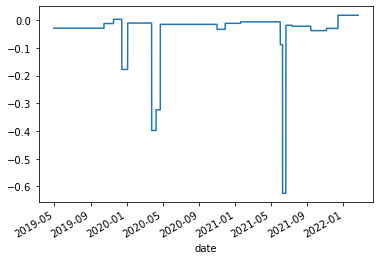

In [100]:
Avions[Avions.engine_serial_number =='ESN_1']['egt_slope'].plot()

In [102]:
Test=Avions.copy()
Test

,engine_serial_number,engine_family,engine_series,cycles,cycles_counter,egt_margin,var_mot_1,flight_leg_hours,event_rank,egt_slope,...,Interpolate_var_mot_1,Interpolate_flight_leg_hours,Interpolate_SV_rank,Interpolate_Config_B_rank,Interpolate_WW_rank,Interpolate_var_env_1,Interpolate_var_env_2,Interpolate_var_env_3,Interpolate_var_env_4,Interpolate_var_env_5
date,,,,,,,,,,,,,,,,,,,,,
2019-04-29 06:29:58,ESN_1,Engine_family_1,Engine_series_1,14.699402,14,0.881646,-0.313549,0.857778,0,-0.029193,...,-0.313549,0.857778,0.0,0.0,0.0,-0.261068,0.193871,0.448627,0.0,0.601803
2019-04-29 08:10:00,ESN_1,Engine_family_1,Engine_series_1,15.284274,15,0.792029,0.006330,0.794167,0,-0.029193,...,0.006330,0.794167,0.0,0.0,0.0,-0.064202,0.273855,1.500848,0.0,-1.056965
2019-04-29 09:55:00,ESN_1,Engine_family_1,Engine_series_1,15.898185,16,0.706729,-0.286324,0.736667,0,-0.029193,...,-0.286324,0.736667,0.0,0.0,0.0,-0.292673,0.193871,0.764293,0.0,0.149412
2019-04-29 11:36:53,ESN_1,Engine_family_1,Engine_series_1,16.493874,17,0.702078,0.430174,0.802500,0,-0.029193,...,0.430174,0.802500,0.0,0.0,0.0,0.070056,0.273855,1.500848,0.0,-1.056965
2019-04-30 04:28:40,ESN_1,Engine_family_1,Engine_series_1,22.409543,18,0.645941,0.299420,0.817500,0,-0.029193,...,0.299420,0.817500,0.0,0.0,0.0,-0.463185,0.193871,0.448627,0.0,0.601803
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-10-26 07:39:15,ESN_1369,Engine_family_1,Engine_series_6,34.993550,50,0.531868,-0.731730,2.654444,0,0.000968,...,-0.731730,2.654444,0.0,0.0,0.0,0.728625,-0.356159,-0.708817,0.0,-1.207762
2022-10-26 11:36:39,ESN_1369,Engine_family_1,Engine_series_6,35.190820,51,0.973045,0.364383,2.501667,0,0.000968,...,0.364383,2.501667,0.0,0.0,0.0,0.421327,-0.351647,-0.077484,0.0,0.199678
2022-10-27 03:55:34,ESN_1369,Engine_family_1,Engine_series_6,36.001950,53,0.800778,0.949444,2.165000,0,0.000968,...,0.949444,2.165000,0.0,0.0,0.0,1.092857,-0.351647,0.343405,0.0,-0.403511


In [109]:
# On fait deux boucles pour limiter le temps de calculs 
# Attention il faut quand même compter 10 minutes pour effectuer cette cellule  
Avion_1= Test[Test['engine_serial_number']==calage_1]
Avion_1 = Avion_1.assign(Interpolate_egt_slope=Avion_1.egt_slope.interpolate(method='pad'))

Avion_2= Test[Test['engine_serial_number']==calage_2]
Avion_2 = Avion_2.assign(Interpolate_egt_slope=Avion_2.egt_slope.interpolate(method='pad'))


for i in series_1 :
    avion_i= Test[Test['engine_serial_number']==i]
    avion= avion_i.assign(Interpolate_egt_slope=avion_i.egt_slope.interpolate(method='pad'))
    Avion_1=pd.concat( [Avion_1,avion])
    print("Chargement de l'avion", i, " sur ", "la première serie (jusqu'à :",series_1[-1],")")
    
for i in series_2 : 
    avion_i= Test[Test['engine_serial_number']==i]
    avion= avion_i.assign(Interpolate_egt_slope=avion_i.egt_slope.interpolate(method='pad'))
    Avion_2 = pd.concat( [Avion_2,avion])
    print("Chargement de l'avion", i, " sur ", "la deuxieme serie (jusqu'à :",series_2[-1],")")


Avions=pd.concat([Avion_1,Avion_2])

Chargement de l'avion ESN_1  sur  la première serie (jusqu'à : ESN_698 )
Chargement de l'avion ESN_2  sur  la première serie (jusqu'à : ESN_698 )
Chargement de l'avion ESN_3  sur  la première serie (jusqu'à : ESN_698 )
Chargement de l'avion ESN_4  sur  la première serie (jusqu'à : ESN_698 )
Chargement de l'avion ESN_5  sur  la première serie (jusqu'à : ESN_698 )
Chargement de l'avion ESN_6  sur  la première serie (jusqu'à : ESN_698 )
Chargement de l'avion ESN_7  sur  la première serie (jusqu'à : ESN_698 )
Chargement de l'avion ESN_8  sur  la première serie (jusqu'à : ESN_698 )
Chargement de l'avion ESN_9  sur  la première serie (jusqu'à : ESN_698 )
Chargement de l'avion ESN_10  sur  la première serie (jusqu'à : ESN_698 )
Chargement de l'avion ESN_11  sur  la première serie (jusqu'à : ESN_698 )
Chargement de l'avion ESN_12  sur  la première serie (jusqu'à : ESN_698 )
Chargement de l'avion ESN_13  sur  la première serie (jusqu'à : ESN_698 )
Chargement de l'avion ESN_14  sur  la première 

1122


<AxesSubplot:xlabel='date'>

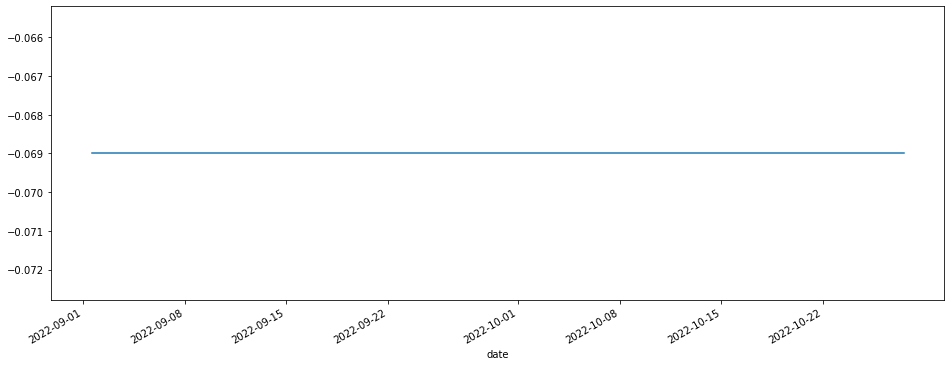

In [116]:
# Affichage de l'évolution du nombre de SV effectué sur un moteur
n=randint(0,len(series))
print(n)
Avions[Avions['engine_serial_number']==series[n]]['Interpolate_egt_slope'].plot(figsize = (16,6))

In [118]:
# On vérifie qu'il n'y a plus de valeur manquante :
Avions.Interpolate_egt_slope.isnull().sum()

3233

Il y a encore des valeurs manquantes, on utilise la méthode backward 

In [120]:
Test = Avions.copy()
Test

,engine_serial_number,engine_family,engine_series,cycles,cycles_counter,egt_margin,var_mot_1,flight_leg_hours,event_rank,egt_slope,...,Interpolate_flight_leg_hours,Interpolate_SV_rank,Interpolate_Config_B_rank,Interpolate_WW_rank,Interpolate_var_env_1,Interpolate_var_env_2,Interpolate_var_env_3,Interpolate_var_env_4,Interpolate_var_env_5,Interpolate_egt_slope
date,,,,,,,,,,,,,,,,,,,,,
2019-04-29 06:29:58,ESN_1,Engine_family_1,Engine_series_1,14.699402,14,0.881646,-0.313549,0.857778,0,-0.029193,...,0.857778,0.0,0.0,0.0,-0.261068,0.193871,0.448627,0.0,0.601803,-0.029193
2019-04-29 08:10:00,ESN_1,Engine_family_1,Engine_series_1,15.284274,15,0.792029,0.006330,0.794167,0,-0.029193,...,0.794167,0.0,0.0,0.0,-0.064202,0.273855,1.500848,0.0,-1.056965,-0.029193
2019-04-29 09:55:00,ESN_1,Engine_family_1,Engine_series_1,15.898185,16,0.706729,-0.286324,0.736667,0,-0.029193,...,0.736667,0.0,0.0,0.0,-0.292673,0.193871,0.764293,0.0,0.149412,-0.029193
2019-04-29 11:36:53,ESN_1,Engine_family_1,Engine_series_1,16.493874,17,0.702078,0.430174,0.802500,0,-0.029193,...,0.802500,0.0,0.0,0.0,0.070056,0.273855,1.500848,0.0,-1.056965,-0.029193
2019-04-30 04:28:40,ESN_1,Engine_family_1,Engine_series_1,22.409543,18,0.645941,0.299420,0.817500,0,-0.029193,...,0.817500,0.0,0.0,0.0,-0.463185,0.193871,0.448627,0.0,0.601803,-0.029193
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-10-26 07:39:15,ESN_1369,Engine_family_1,Engine_series_6,34.993550,50,0.531868,-0.731730,2.654444,0,0.000968,...,2.654444,0.0,0.0,0.0,0.728625,-0.356159,-0.708817,0.0,-1.207762,0.000968
2022-10-26 11:36:39,ESN_1369,Engine_family_1,Engine_series_6,35.190820,51,0.973045,0.364383,2.501667,0,0.000968,...,2.501667,0.0,0.0,0.0,0.421327,-0.351647,-0.077484,0.0,0.199678,0.000968
2022-10-27 03:55:34,ESN_1369,Engine_family_1,Engine_series_6,36.001950,53,0.800778,0.949444,2.165000,0,0.000968,...,2.165000,0.0,0.0,0.0,1.092857,-0.351647,0.343405,0.0,-0.403511,0.000968


In [122]:
# On fait deux boucles pour limiter le temps de calculs 
# Attention il faut quand même compter 10 minutes pour effectuer cette cellule  
Avion_1= Test[Test['engine_serial_number']==calage_1]
Avion_1 = Avion_1.assign(Interpolate_egt_slope=Avion_1.Interpolate_egt_slope.interpolate(method='time',limit_direction='backward'))

Avion_2= Test[Test['engine_serial_number']==calage_2]
Avion_2 = Avion_2.assign(Interpolate_egt_slope=Avion_2.Interpolate_egt_slope.interpolate(method='time',limit_direction='backward'))


for i in series_1 :
    avion_i= Test[Test['engine_serial_number']==i]
    if i in Test[Test['Interpolate_egt_slope'].isnull()==True]['engine_serial_number'].unique(): 
        avion= avion_i.assign(Interpolate_egt_slope=avion_i.Interpolate_egt_slope.interpolate(method='time', limit_direction='backward'))
        Avion_1=pd.concat( [Avion_1,avion])
        print("Chargement de l'avion", i, " sur ", "la première serie (jusqu'à :",series_1[-1],")")
    else :
        Avion_1=pd.concat( [Avion_1,avion_i])
        print("Chargement de l'avion", i, " sur ", "la première serie (jusqu'à :",series_1[-1],")")
        
for i in series_2 : 
    avion_i= Test[Test['engine_serial_number']==i]
    if i in Test[Test['Interpolate_egt_slope'].isnull()==True]['engine_serial_number'].unique(): 
        avion= avion_i.assign(Interpolate_egt_slope=avion_i.Interpolate_egt_slope.interpolate(method='time', limit_direction='backward'))
        Avion_2 = pd.concat( [Avion_2,avion])
        print("Chargement de l'avion", i, " sur ", "la deuxieme serie (jusqu'à :",series_2[-1],")")
    else :
        Avion_2=pd.concat( [Avion_2,avion_i])
        print("Chargement de l'avion", i, " sur ", "la première serie (jusqu'à :",series_1[-1],")")
    
Avions=pd.concat([Avion_1,Avion_2])

Chargement de l'avion ESN_1  sur  la première serie (jusqu'à : ESN_698 )
Chargement de l'avion ESN_2  sur  la première serie (jusqu'à : ESN_698 )
Chargement de l'avion ESN_3  sur  la première serie (jusqu'à : ESN_698 )
Chargement de l'avion ESN_4  sur  la première serie (jusqu'à : ESN_698 )
Chargement de l'avion ESN_5  sur  la première serie (jusqu'à : ESN_698 )
Chargement de l'avion ESN_6  sur  la première serie (jusqu'à : ESN_698 )
Chargement de l'avion ESN_7  sur  la première serie (jusqu'à : ESN_698 )
Chargement de l'avion ESN_8  sur  la première serie (jusqu'à : ESN_698 )
Chargement de l'avion ESN_9  sur  la première serie (jusqu'à : ESN_698 )
Chargement de l'avion ESN_10  sur  la première serie (jusqu'à : ESN_698 )
Chargement de l'avion ESN_11  sur  la première serie (jusqu'à : ESN_698 )
Chargement de l'avion ESN_12  sur  la première serie (jusqu'à : ESN_698 )
Chargement de l'avion ESN_13  sur  la première serie (jusqu'à : ESN_698 )
Chargement de l'avion ESN_14  sur  la première 

In [123]:
Avions.Interpolate_egt_slope.isnull().sum()

153

Encore des valeurs manquantes

In [124]:
Avions[Avions['Interpolate_egt_slope'].isnull()==True]['engine_serial_number'].unique()

array(['ESN_922', 'ESN_1264'], dtype=object)

La pente pose problème pour deux moteurs. 

In [128]:
Avions[Avions['Interpolate_egt_margin'].isnull()==True]['engine_serial_number'].unique()

array([], dtype=object)

La pente est absente pour ces deux avions mais peut être retrouver à l'aide de la variable "Interpolate EGT margin". 
La pente est calculée entre deux événements de Water Washer : Event Rank

In [130]:
Avions[Avions['engine_serial_number']=='ESN_922']['event_rank'].unique()

array([0], dtype=int64)

Pour cet avion ( ESN_922) il n'y a eu aucun événement d'entretien. La pente est donc le résultat de la différence entre la norme EGT du dernier vol - la norme egt du premier vol, le tout divisé par 50. 

In [131]:
Avions[Avions['engine_serial_number']=='ESN_1264']['event_rank'].unique()

array([0], dtype=int64)

In [161]:
Avions[Avions['engine_serial_number']=='ESN_1264']['Interpolate_egt_margin'][-1]

0.013150517049414029

In [ ]:
(Avions.index[Avions['flight_leg_hours'].isnull()